In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch 
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F



from utils.utils import *
from utils.model_setup import CoinDataset

train_folder = 'data/train_coins'



/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
label_list = ['5CHF', '2CHF', '1CHF', '0.5CHF', '0.2CHF', '0.1CHF', '0.05CHF',
       '2EUR', '1EUR', '0.5EUR', '0.2EUR', '0.1EUR', '0.05EUR', '0.02EUR',
       '0.01EUR', 'OOD']

def one_hot_encode(label, label_list):
    # Create an array of zeros of length num_classes
    num_classes = len(label_list)
    one_hot = np.zeros(num_classes)
    # Set the appropriate element to one
    one_hot = label_list.index(label)#[int(label == l) for l in label_list]
    return one_hot

# 3. Classification

In [3]:
x = load_images_from_folder(train_folder)
data = pd.read_csv(train_folder+'/labels.csv')
y_labels = data['labels'].values
y = [one_hot_encode(label,label_list) for label in y_labels]

random.seed(42)
shuffle = random.sample(range(len(x)), k=len(x))
x = [x[i] for i in shuffle]
y = [y[i] for i in shuffle]

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]

x_val = x[int(0.8*len(x)):]
y_val = y[int(0.8*len(y)):]

In [4]:
x_train = [x_train[i] for i in range(len(x_train)) if y_train[i]!=15]
y_train = [y_train[i] for i in range(len(y_train)) if y_train[i]!=15]

x_val = [x_val[i] for i in range(len(x_val)) if y_val[i]!=15]
y_val = [y_val[i] for i in range(len(y_val)) if y_val[i]!=15]

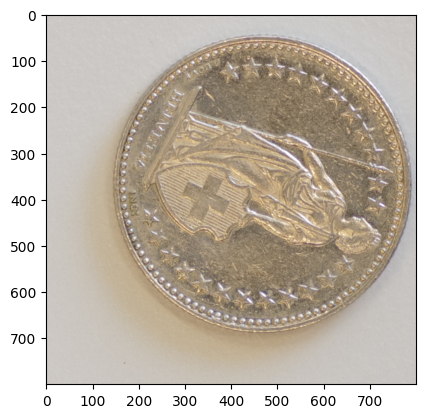

1


In [5]:
idx = 10
plt.imshow(x_train[idx])
plt.show()

print(y_train[idx])

In [6]:
# Load pre-trained ResNet-50 model
model = models.resnet50(weights="IMAGENET1K_V2")
augment = True

In [7]:
num_classes = 15  # number of coin types

# Replace the last fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.fc = torch.nn.Sequential(nn.Linear(model.fc.in_features, num_classes*100),
                               nn.BatchNorm1d(num_classes*100),
                               nn.ReLU(),
                               nn.Dropout(0.5),
                               nn.Linear(num_classes*100, num_classes))

# nn.Linear(num_classes*100, num_classes*10),
#                                nn.BatchNorm1d(num_classes*10),
#                                nn.ReLU(),
#                                nn.Dropout(0.5),
#                                nn.Linear(num_classes*10, num_classes*10),
#                                nn.BatchNorm1d(num_classes*10),
#                                nn.ReLU(),
#                                nn.Dropout(0.5),



# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

# define transforms
valid_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((80, 80)),
        transforms.ToTensor(),
        normalize,
])
if augment:
   train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((80, 80)),  # Resize to the desired size for your model
    transforms.RandomRotation(180),  # Full 360 degree rotation
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Small translations
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Small perspective changes
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.ToTensor(),  # Convert image to tensor for model input
    normalize,  # Normalize the image
])
else:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((80, 80)),
        transforms.ToTensor(),
        normalize,
    ])

# Assuming you have a directory with 'train' and 'val' subdirectories
train_dataset = CoinDataset(x_train, y_train, transform=train_transform)
valid_dataset = CoinDataset(x_val, y_val, transform=valid_transform)
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [8]:
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Name:", torch.cuda.get_device_name(0))  # Print the name of the GPU
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is not available, using CPU instead


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # Optimize only the last layer

# Train the model
model.train()
n_epochs = 20

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch')

    losses = []
    correct_train = 0
    total_train = 0


    for batch_idx, (features, labels) in enumerate(progress_bar):

        optimizer.zero_grad() #set gradient to zero before starting
    
        
        preds = model(features)
        loss = F.cross_entropy(preds, labels)

        loss.backward()
        optimizer.step()


        # _, train_losses[epoch] = test(model, train_loader)
        _, predicted_train = torch.max(F.softmax(preds, dim=1).data, 1)
        total_train += labels.size(0)
        # print(total_train)
        correct_train += (predicted_train == labels).sum().item()
        train_accuracy =  correct_train / total_train

        losses.append(loss.item())
        epoch_train_loss = np.mean(losses)

        progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy)


        if batch_idx == len(train_loader) - 1:
            # Calculate validation set accuracy
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images,labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_accuracy =  correct_val / total_val

        #     # Save metrics
            train_losses.append(np.mean(sum(losses)))
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Update progress bar postfix with validation set accuracy
            progress_bar.set_postfix(loss=epoch_train_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy)      

Epoch 1/20:   0%|          | 0/17 [00:00<?, ?batch/s]

Epoch 9/20:  94%|█████████▍| 16/17 [00:06<00:00,  2.39batch/s, loss=1.89, train_accuracy=0.419]


KeyboardInterrupt: 

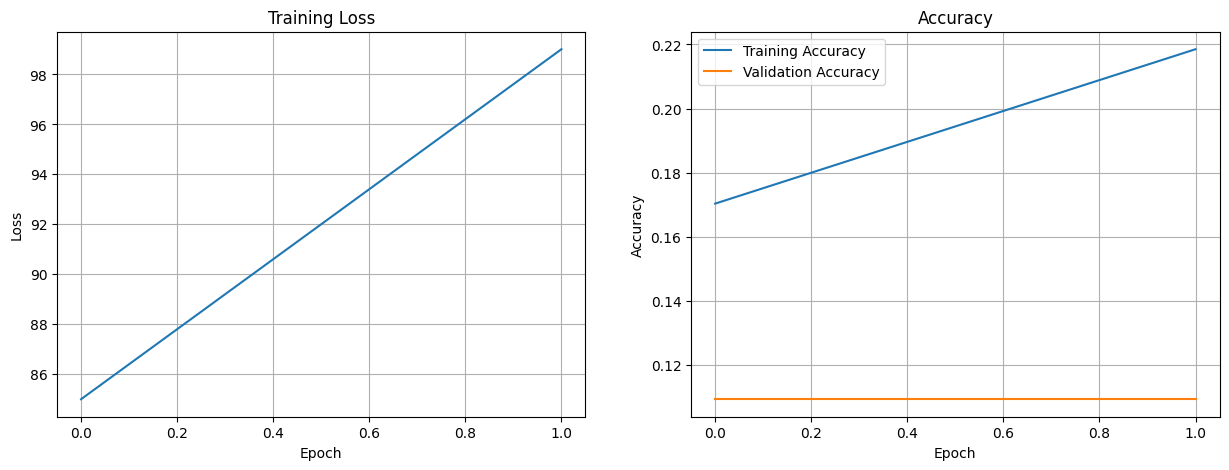

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()
plt.show()
